In [ ]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import math
import matplotlib.pyplot as plt


In [ ]:
# Import necessary libraries
import pandas as pd
import plotly.io as pio
from google.colab import drive  # Import the drive object

# Mount Google Drive
drive.mount('/content/drive')

# Load dataset
file_path = "/content/Bright_Tree.png"

Mounted at /content/drive


<ipython-input-3-f5e5c5bcdc65>:46: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


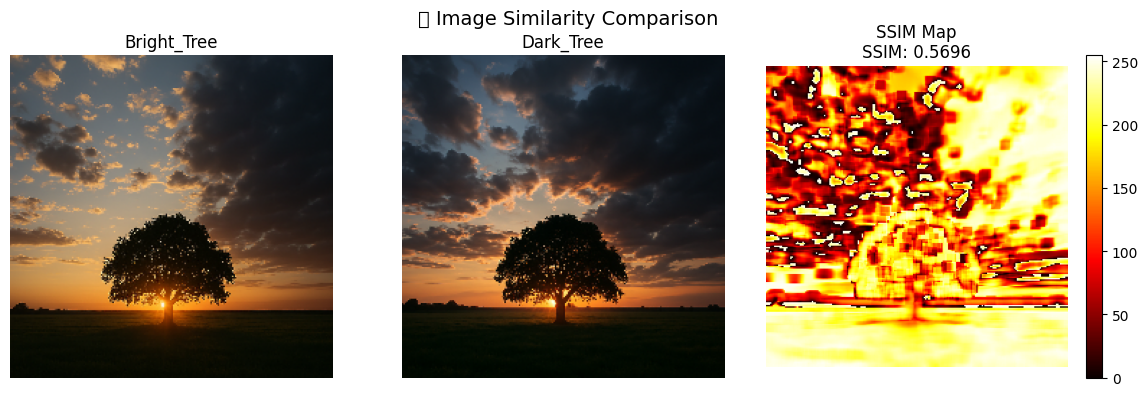

 Similarity Metrics:
 MSE  : 72.35
 PSNR : 29.54 dB
 SSIM : 0.5696


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from math import log10

# Load the images
img1_path = "/content/Bright_Tree.png"
img2_path = "/content/Dark_Tree.png"
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

# Resize and convert to grayscale
img1 = cv2.resize(img1, (224, 224))
img2 = cv2.resize(img2, (224, 224))
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Compute metrics
mse = np.mean((gray1 - gray2) ** 2)
psnr = 20 * log10(255.0 / np.sqrt(mse)) if mse != 0 else float('inf')
ssim_score, diff_map = ssim(gray1, gray2, full=True)
diff_map = (diff_map * 255).astype("uint8")

# --- VISUALIZATION STARTS HERE ---

# Plot original images
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title("Bright_Tree")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title("Dark_Tree")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(diff_map, cmap='hot')
plt.title(f"SSIM Map\nSSIM: {ssim_score:.4f}")
plt.colorbar()
plt.axis("off")

plt.suptitle("🔍 Image Similarity Comparison", fontsize=14)
plt.tight_layout()
plt.show()

# Print metrics
print(" Similarity Metrics:")
print(f" MSE  : {mse:.2f}")
print(f" PSNR : {psnr:.2f} dB")
print(f" SSIM : {ssim_score:.4f}")


In [ ]:
# Install selective_search if not already installed
!pip install -q selective_search

# Import required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import selective_search
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.models import Model

# Load the VGG16 model with pretrained ImageNet weights
model = VGG16(weights='imagenet')

# Load the image from the specified path
image_path = "/content/StreetView.jpg"
image = cv2.imread(image_path)

# Convert to RGB format for compatibility with Keras and matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Apply Selective Search to generate region proposals
regions = selective_search.selective_search(image_rgb, mode='single', random_sort=False)

# Filter out duplicate and small regions
candidates = set()
for r in regions:
    x, y, w, h = r
    if (x, y, w, h) in candidates:
        continue
    if w * h < 2000 or w == 0 or h == 0:
        continue
    candidates.add((x, y, w, h))

# Classify top region proposals using pretrained VGG16
for (x, y, w, h) in list(candidates)[:100]:  # Limit to first 100 regions for performance
    roi = image[y:y+h, x:x+w]
    if roi.shape[0] < 10 or roi.shape[1] < 10:
        continue
    resized = cv2.resize(roi, (224, 224))
    input_tensor = preprocess_input(np.expand_dims(resized.astype(np.float32), axis=0))

    preds = model.predict(input_tensor)
    decoded = decode_predictions(preds, top=1)[0][0]
    label, confidence = decoded[1], decoded[2]

    if confidence > 0.5:
        cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(
            image_rgb,
            f"{label} ({confidence:.2f})",
            (x, y - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 0, 0),
            1
        )

# Display the result
plt.figure(figsize=(12, 8))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("Original R-CNN on StreetView (No Training)")
plt.show()


In [ ]:
img3_path = "/content/Kitchen.jpg"
img4_path = "/content/StreetView.jpg"
img5_path = "/content/Zebra.jpg"



# Install selective search library if not already installed
!pip install selective_search

# Import required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import selective_search
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.models import Model

def detect_objects_in_image(image_path, top_n=100, min_size=2000, conf_threshold=0.5):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Run Selective Search (no extra parameters allowed here)
    ss_results = selective_search.selective_search(image_rgb)

    candidates = set()
    for r in ss_results:
        x, y, w, h = r
        if w * h < min_size or w == 0 or h == 0:
            continue
        candidates.add((x, y, w, h))

    detections = []
    for (x, y, w, h) in list(candidates)[:top_n]:
        roi = image[y:y+h, x:x+w]
        if roi.shape[0] < 20 or roi.shape[1] < 20:
            continue

        resized = cv2.resize(roi, (224, 224))
        input_tensor = preprocess_input(np.expand_dims(resized.astype(np.float32), axis=0))
        preds = model.predict(input_tensor)
        decoded = decode_predictions(preds, top=1)[0][0]
        label, confidence = decoded[1], decoded[2]

        if confidence > conf_threshold:
            detections.append((label, confidence, (x, y, w, h)))
            cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (255, 0, 0), 2)
            cv2.putText(image_rgb, f"{label} ({confidence:.2f})", (x, y - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    return image_rgb, detections


In [ ]:
!pip install selectivesearch
import selectivesearch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from math import log10


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━

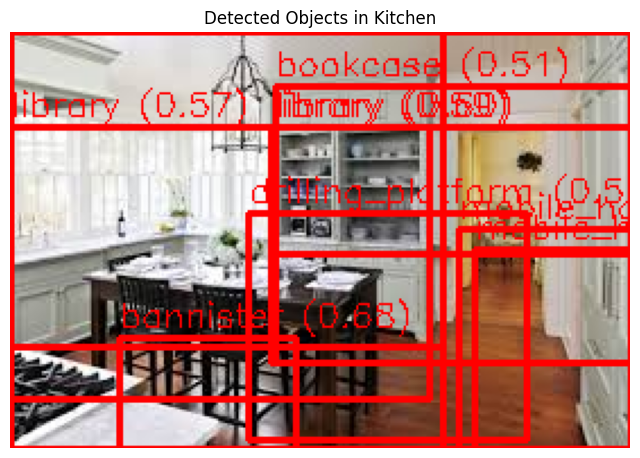


🔍 Detections in Kitchen:
 - library (0.57)
 - library (0.72)
 - drilling_platform (0.54)
 - bookcase (0.51)
 - library (0.59)
 - bannister (0.68)
 - library (0.60)
 - mobile_home (0.60)
 - library (0.84)
 - mobile_home (0.55)
 - library (0.65)


In [ ]:
# Load pretrained VGG16 model from Keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.models import Model

# Load the pre-trained model once
model = VGG16(weights='imagenet')



image_paths = {
    "Kitchen": "/content/Kitchen.jpg",

}

results = {}

# Perform detection and visualize
for name, path in image_paths.items():
    result_img, detections = detect_objects_in_image(path)
    results[name] = detections

    # Show image with bounding boxes
    plt.figure(figsize=(8, 6))
    plt.imshow(result_img)
    plt.title(f"Detected Objects in {name}")
    plt.axis("off")
    plt.show()

    # Print detections
    print(f"\n🔍 Detections in {name}:")
    for label, conf, _ in detections:
        print(f" - {label} ({conf:.2f})")


In [ ]:
# Install selective_search if not already installed
!pip install -q selective_search

# Import required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import selective_search
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.models import Model

# Load the VGG16 model with pretrained ImageNet weights
model = VGG16(weights='imagenet')

# Load the image from the specified path
image_path = "/content/StreetView.jpg"
image = cv2.imread(image_path)

# Convert to RGB format for compatibility with Keras and matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Apply Selective Search to generate region proposals
regions = selective_search.selective_search(image_rgb, mode='single', random_sort=False)

# Filter out duplicate and small regions
candidates = set()
for r in regions:
    x, y, w, h = r
    if (x, y, w, h) in candidates:
        continue
    if w * h < 2000 or w == 0 or h == 0:
        continue
    candidates.add((x, y, w, h))

# Classify top region proposals using pretrained VGG16
for (x, y, w, h) in list(candidates)[:100]:  # Limit to first 100 regions for performance
    roi = image[y:y+h, x:x+w]
    if roi.shape[0] < 10 or roi.shape[1] < 10:
        continue
    resized = cv2.resize(roi, (224, 224))
    input_tensor = preprocess_input(np.expand_dims(resized.astype(np.float32), axis=0))

    preds = model.predict(input_tensor)
    decoded = decode_predictions(preds, top=1)[0][0]
    label, confidence = decoded[1], decoded[2]

    if confidence > 0.5:
        cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(
            image_rgb,
            f"{label} ({confidence:.2f})",
            (x, y - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 0, 0),
            1
        )

# Display the result
plt.figure(figsize=(12, 8))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("Original R-CNN on StreetView (No Training)")
plt.show()


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1

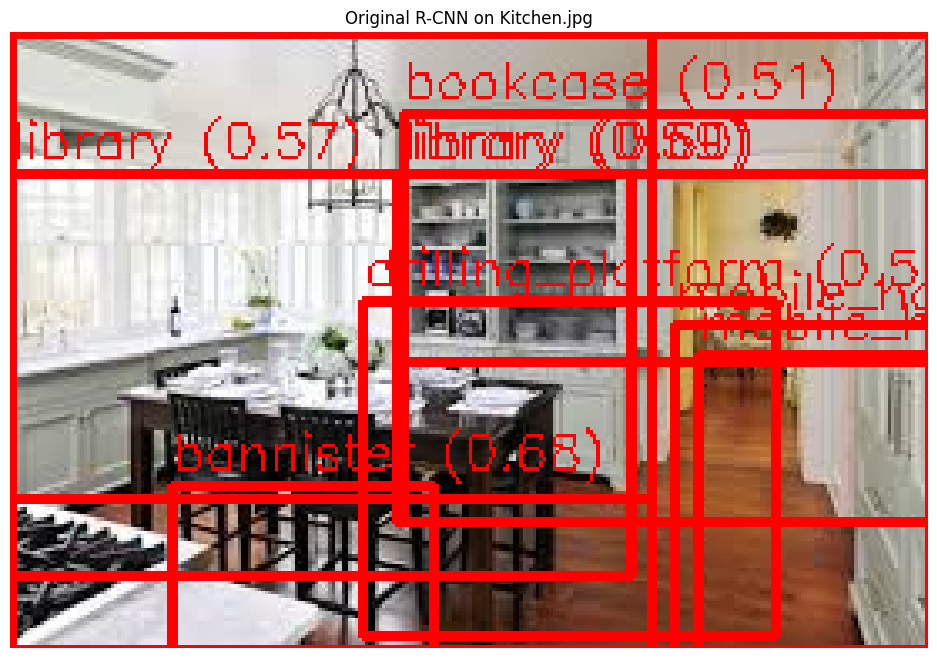

In [ ]:
# rcnn_kitchen.py - Original R-CNN-style object detection on Kitchen.jpg

import cv2
import numpy as np
import matplotlib.pyplot as plt
import selective_search
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.models import Model

# Load pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Load the image
image = cv2.imread('/content/Zebra.jpg')
if image is None:
    raise FileNotFoundError("Image not found. Make sure /content/Zebra.jpg exists.")

# Convert BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

regions = selective_search.selective_search(image_rgb, mode='single', random_sort=False)

# Filter proposals
candidates = set()
for r in regions:
    x, y, w, h = r
    if (x, y, w, h) in candidates:
        continue
    if w * h < 2000 or w == 0 or h == 0:
        continue
    candidates.add((x, y, w, h))

# Classify top region proposals using VGG16
for (x, y, w, h) in list(candidates)[:100]:  # Only first 100 to save time
    roi = image[y:y+h, x:x+w]
    if roi.shape[0] < 10 or roi.shape[1] < 10:
        continue

    resized = cv2.resize(roi, (224, 224))
    input_tensor = preprocess_input(np.expand_dims(resized.astype(np.float32), axis=0))

    preds = model.predict(input_tensor)
    decoded = decode_predictions(preds, top=1)[0][0]
    label, confidence = decoded[1], decoded[2]

    if confidence > 0.5:
        cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(
            image_rgb,
            f"{label} ({confidence:.2f})",
            (x, y - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 0, 0),
            1
        )

# Show the final image
plt.figure(figsize=(12, 8))
plt.imshow(image_rgb)
plt.axis('off')
plt.title(" Zebra.jpg")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


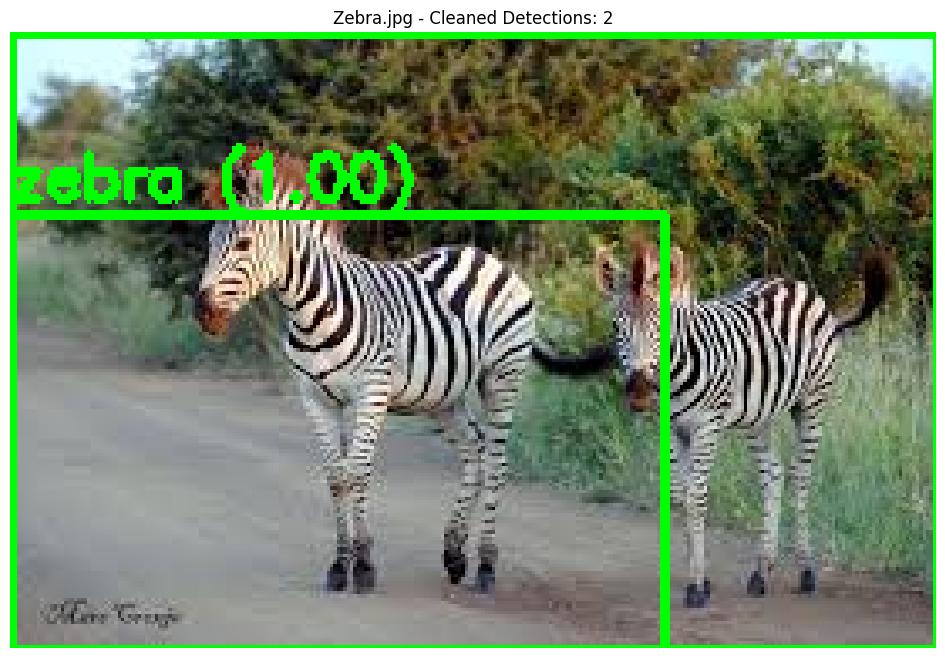

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import selective_search
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

# Load model
model = VGG16(weights='imagenet')

# Load Zebra image
image = cv2.imread('/content/Zebra.jpg')
if image is None:
    raise FileNotFoundError("Image not found")

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Selective Search
regions = selective_search.selective_search(image_rgb, mode='single', random_sort=False)

# Filter region proposals
candidates = []
seen = set()
for r in regions:
    x, y, w, h = r
    if (x, y, w, h) in seen or w * h < 3000 or w == 0 or h == 0:
        continue
    seen.add((x, y, w, h))
    candidates.append((x, y, w, h))

# Classify region proposals
detections = []
for (x, y, w, h) in candidates[:20]:  # Only 20 regions
    roi = image[y:y+h, x:x+w]
    if roi.shape[0] < 10 or roi.shape[1] < 10:
        continue
    resized = cv2.resize(roi, (224, 224))
    input_tensor = preprocess_input(np.expand_dims(resized.astype(np.float32), axis=0))

    preds = model.predict(input_tensor)
    label, conf = decode_predictions(preds, top=1)[0][0][1:3]

    if conf > 0.85 and label == 'zebra':
        detections.append((label, conf, (x, y, w, h)))

# Draw only the best boxes
for label, conf, (x, y, w, h) in detections:
    cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image_rgb, f"{label} ({conf:.2f})", (x, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# Show output
plt.figure(figsize=(12, 8))
plt.imshow(image_rgb)
plt.title(f"Zebra.jpg - Cleaned Detections: {len(detections)}")
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━

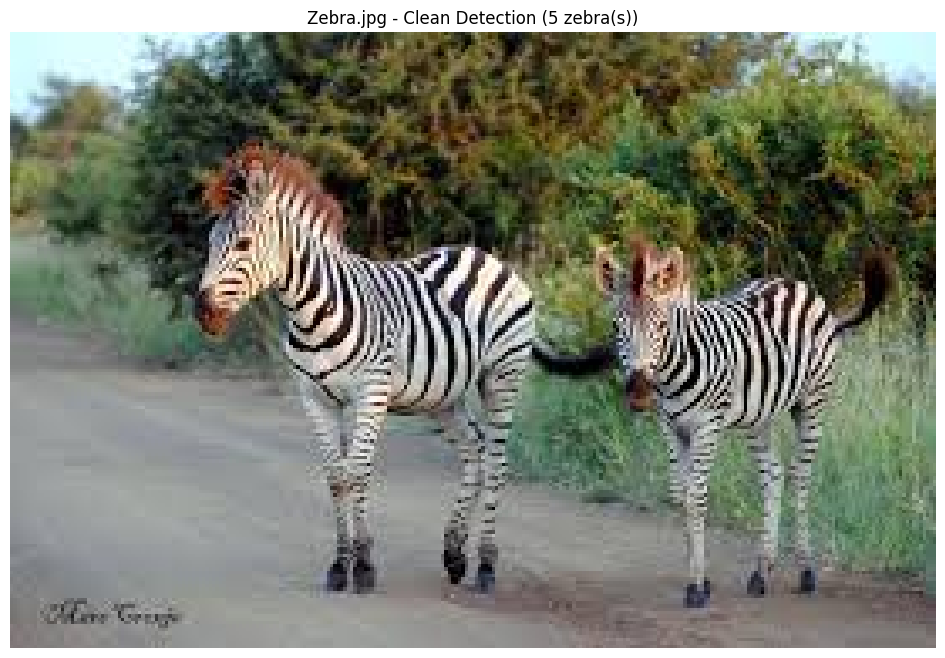

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import selective_search
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

# Load VGG16
model = VGG16(weights='imagenet')

# Load image
image = cv2.imread('/content/Zebra.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Selective Search
regions = selective_search.selective_search(image_rgb, mode='single', random_sort=False)

# Proposal filtering
candidates = []
seen = set()
for x, y, w, h in regions:
    if (x, y, w, h) in seen or w * h < 2500:
        continue
    seen.add((x, y, w, h))
    candidates.append((x, y, w, h))

# Detect and store zebras
boxes = []
scores = []
for (x, y, w, h) in candidates[:200]:
    roi = image[y:y+h, x:x+w]
    if roi.shape[0] < 20 or roi.shape[1] < 20:
        continue
    resized = cv2.resize(roi, (224, 224))
    input_tensor = preprocess_input(np.expand_dims(resized.astype(np.float32), axis=0))
    preds = model.predict(input_tensor)
    label, conf = decode_predictions(preds, top=1)[0][0][1:3]
    if label == 'zebra' and conf > 0.90:
        boxes.append([x, y, x + w, y + h])
        scores.append(conf)

## Apply Non-Maximum Suppression (NMS)
indices = cv2.dnn.NMSBoxes(boxes, scores, score_threshold=0.9, nms_threshold=0.3)

# Check if indices is empty or a scalar before indexing
if indices is None or indices.size == 0:  # Handle empty or scalar cases
    final_boxes = []
else:
    # If indices is multi-dimensional, use the original indexing
    if indices.ndim > 1:
        final_boxes = [boxes[i[0]] for i in indices]
    # If indices is 1-dimensional, directly index boxes
    else:
        final_boxes = [boxes[i] for i in indices]

# Show image
plt.figure(figsize=(12, 8))
plt.imshow(image_rgb)
plt.axis('off')
plt.title(f"Zebra.jpg - Clean Detection ({len(final_boxes)} zebra(s))")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━

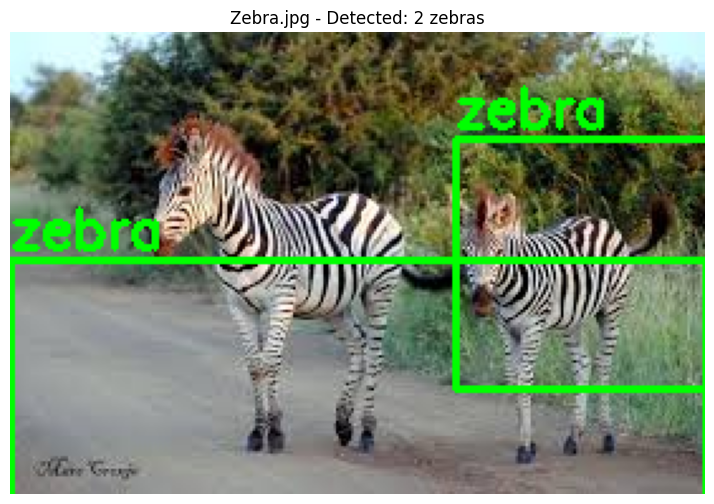

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import selective_search
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.models import Model

# Load pre-trained VGG16
model = VGG16(weights='imagenet')

# Load and prepare image
image = cv2.imread('/content/Zebra.jpg')
if image is None:
    raise FileNotFoundError("Image not found at /content/Zebra.jpg")

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run Selective Search
regions = selective_search.selective_search(image_rgb, mode='fast', random_sort=False)

# Filter region proposals
candidates = set()
for r in regions:
    x, y, w, h = r
    if w * h < 2000 or w == 0 or h == 0:
        continue
    candidates.add((x, y, w, h))

# Helper: Non-Max Suppression (NMS) for overlap filtering
def non_max_suppression_fast(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    boxes = np.array(boxes)
    pick = []
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,0] + boxes[:,2]
    y2 = boxes[:,1] + boxes[:,3]
    area = (x2 - x1) * (y2 - y1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = idxs[-1]
        pick.append(last)
        suppress = [last]

        for pos in idxs[:-1]:
            xx1 = max(x1[last], x1[pos])
            yy1 = max(y1[last], y1[pos])
            xx2 = min(x2[last], x2[pos])
            yy2 = min(y2[last], y2[pos])
            w = max(0, xx2 - xx1)
            h = max(0, yy2 - yy1)
            overlap = (w * h) / area[pos]
            if overlap > overlapThresh:
                suppress.append(pos)
        idxs = np.setdiff1d(idxs, suppress)

    return boxes[pick].astype("int")

# Detection and Filtering
detections = []
for (x, y, w, h) in list(candidates)[:200]:
    roi = image[y:y+h, x:x+w]
    if roi.shape[0] < 20 or roi.shape[1] < 20:
        continue

    resized = cv2.resize(roi, (224, 224))
    input_tensor = preprocess_input(np.expand_dims(resized.astype(np.float32), axis=0))
    preds = model.predict(input_tensor)
    decoded = decode_predictions(preds, top=1)[0][0]
    label, confidence = decoded[1], decoded[2]

    if label == 'zebra' and confidence > 0.8:
        detections.append((label, confidence, (x, y, w, h)))

# Apply NMS to remove redundant detections
boxes = [det[2] for det in detections]
nms_boxes = non_max_suppression_fast(boxes, overlapThresh=0.3)

# Draw only top N boxes (e.g., 2)
for (x, y, w, h) in nms_boxes[:2]:
    cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(
        image_rgb,
        "zebra",
        (x, y - 5),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7,
        (0, 255, 0),
        2
    )

# Show the final image
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title(f"Zebra.jpg - Detected: {len(nms_boxes[:2])} zebras")
plt.show()


In [ ]:
# Install dependencies (if not already installed)
!pip install selective_search

# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import selective_search
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.models import Model

# Load VGG16 model pre-trained on ImageNet
model = VGG16(weights='imagenet')

# Load and prepare the image (Change this to your image path)
image_path = "/content/StreetView.jpg"
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run Selective Search
regions = selective_search.selective_search(image_rgb, mode='fast', random_sort=False)

# Filter out tiny or duplicate regions
candidates = set()
for r in regions:
    x, y, w, h = r
    if (x, y, w, h) in candidates:
        continue
    if w * h < 2000 or w == 0 or h == 0:
        continue
    candidates.add((x, y, w, h))

# Run VGG16 classification on top region proposals
detections = []
for (x, y, w, h) in list(candidates)[:100]:  # Limit to 100 proposals
    roi = image[y:y+h, x:x+w]
    if roi.shape[0] < 20 or roi.shape[1] < 20:
        continue

    resized = cv2.resize(roi, (224, 224))
    input_tensor = preprocess_input(np.expand_dims(resized.astype(np.float32), axis=0))

    # Predict with verbose=0 (no progress bar)
    preds = model.predict(input_tensor, verbose=0)
    decoded = decode_predictions(preds, top=1)[0][0]
    label, confidence = decoded[1], decoded[2]

    if confidence > 0.5:  # Filter high confidence only
        detections.append((label, confidence, (x, y, w, h)))
        cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(
            image_rgb,
            f"{label} ({confidence:.2f})",
            (x, y - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 255, 0),
            1
        )

# Show image with bounding boxes
plt.figure(figsize=(12, 8))
plt.imshow(image_rgb)
plt.axis('off')
plt.title(f"{image_path.split('/')[-1]} - Detected: {len(detections)} object(s)")
plt.show()

# Print detection summary
print(f"\nDetections in {image_path.split('/')[-1]}:")
for label, conf, _ in detections:
    print(f" - {label} ({conf:.2f})")


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import selective_search
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.models import Model

# --- Non-Maximum Suppression to reduce overlapping boxes ---
def non_max_suppression_fast(boxes, scores, overlapThresh=0.3):
    if len(boxes) == 0:
        return [], []

    boxes = np.array(boxes)
    scores = np.array(scores)

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = x1 + boxes[:, 2]
    y2 = y1 + boxes[:, 3]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)[::-1]

    pick = []
    while len(idxs) > 0:
        i = idxs[0]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[1:]])
        yy1 = np.maximum(y1[i], y1[idxs[1:]])
        xx2 = np.minimum(x2[i], x2[idxs[1:]])
        yy2 = np.minimum(y2[i], y2[idxs[1:]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / areas[idxs[1:]]
        idxs = idxs[np.where(overlap <= overlapThresh)[0] + 1]

    return boxes[pick], scores[pick]

# --- Load VGG16 model ---
model = VGG16(weights='imagenet')

# --- Load image ---
image = cv2.imread('/content/StreetView.jpg')
if image is None:
    raise FileNotFoundError("Image not found at /content/StreetView.jpg")

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# --- Region Proposals using Selective Search ---
regions = selective_search.selective_search(image_rgb, mode='single', random_sort=False)

# --- Filter regions ---
candidates = []
for x, y, w, h in regions:
    if w * h < 2000 or w == 0 or h == 0:
        continue
    candidates.append((x, y, w, h))

# --- Classify proposals ---
boxes = []
scores = []
labels = []

for (x, y, w, h) in candidates[:150]:  # Limit to top 150 for speed
    roi = image[y:y+h, x:x+w]
    if roi.shape[0] < 10 or roi.shape[1] < 10:
        continue

    resized = cv2.resize(roi, (224, 224))
    input_tensor = preprocess_input(np.expand_dims(resized.astype(np.float32), axis=0))
    preds = model.predict(input_tensor)
    decoded = decode_predictions(preds, top=1)[0][0]

    label, confidence = decoded[1], decoded[2]

    if confidence > 0.65:
        boxes.append((x, y, w, h))
        scores.append(confidence)
        labels.append(label)

# --- Apply Non-Maximum Suppression ---
filtered_boxes, filtered_scores = non_max_suppression_fast(boxes, scores)

# --- Draw final boxes ---
for i, (x, y, w, h) in enumerate(filtered_boxes):
    label_text = f"{labels[i]} ({filtered_scores[i]:.2f})"
    cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image_rgb, label_text, (x, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

# --- Show the final output ---
plt.figure(figsize=(12, 8))
plt.imshow(image_rgb)
plt.axis("off")
plt.title(f"StreetView.jpg - Clean Detection ({len(filtered_boxes)} object(s))")
plt.show()


In [ ]:
# rcnn_streetview.py - R-CNN with VGG16 + Selective Search + NMS for StreetView.jpg

import cv2
import numpy as np
import matplotlib.pyplot as plt
import selective_search
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.models import Model

# Load pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Load and prepare image
image = cv2.imread('/content/StreetView.jpg')
if image is None:
    raise FileNotFoundError("Image not found at /content/StreetView.jpg")

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Apply Selective Search (use 'fast' for speed)
regions = selective_search.selective_search(image_rgb, mode='fast', random_sort=False)

# Filter region proposals
candidates = set()
for r in regions:
    x, y, w, h = r
    if w * h < 2000 or w == 0 or h == 0:
        continue
    candidates.add((x, y, w, h))

# Define vehicle/street object labels of interest
target_labels = {'car', 'bus', 'minibus', 'cab', 'taxi', 'ambulance', 'jeep', 'streetcar', 'tow_truck'}

# Non-Max Suppression
def non_max_suppression_fast(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    boxes = np.array(boxes)
    pick = []
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,0] + boxes[:,2]
    y2 = boxes[:,1] + boxes[:,3]
    area = (x2 - x1) * (y2 - y1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = idxs[-1]
        pick.append(last)
        suppress = [last]
        for pos in idxs[:-1]:
            xx1 = max(x1[last], x1[pos])
            yy1 = max(y1[last], y1[pos])
            xx2 = min(x2[last], x2[pos])
            yy2 = min(y2[last], y2[pos])
            w = max(0, xx2 - xx1)
            h = max(0, yy2 - yy1)
            overlap = (w * h) / area[pos]
            if overlap > overlapThresh:
                suppress.append(pos)
        idxs = np.setdiff1d(idxs, suppress)
    return boxes[pick].astype("int")

# Run predictions on candidate regions
detections = []
for (x, y, w, h) in list(candidates)[:300]:
    roi = image[y:y+h, x:x+w]
    if roi.shape[0] < 20 or roi.shape[1] < 20:
        continue

    resized = cv2.resize(roi, (224, 224))
    input_tensor = preprocess_input(np.expand_dims(resized.astype(np.float32), axis=0))
    preds = model.predict(input_tensor, verbose=0)
    decoded = decode_predictions(preds, top=1)[0][0]
    label, confidence = decoded[1], decoded[2]

    if label in target_labels and confidence > 0.6:
        detections.append((label, confidence, (x, y, w, h)))

# Apply NMS
boxes = [det[2] for det in detections]
nms_boxes = non_max_suppression_fast(boxes, 0.3)

# Draw final top detections (max 5)
for (x, y, w, h) in nms_boxes[:5]:
    cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 255), 2)
    cv2.putText(
        image_rgb,
        "vehicle",
        (x, y - 5),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (0, 255, 255),
        2
    )

# Show output
plt.figure(figsize=(12, 8))
plt.imshow(image_rgb)
plt.axis("off")
plt.title(f"StreetView.jpg - Detected: {len(nms_boxes[:5])} vehicle(s)")
plt.show()
